In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetLarge,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = NASNetLarge(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=16, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 173s 55ms/step - loss: 0.5844 - acc: 0.8368 - val_loss: 6.2834 - val_acc: 0.6061
Epoch 2/100
3144/3144 [==============================] - 148s 47ms/step - loss: 0.3902 - acc: 0.8877 - val_loss: 3.7087 - val_acc: 0.7433
Epoch 3/100
3144/3144 [==============================] - 148s 47ms/step - loss: 0.3765 - acc: 0.9027 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 4/100
3144/3144 [==============================] - 174s 55ms/step - loss: 0.8475 - acc: 0.8165 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 5/100
3144/3144 [==============================] - 359s 114ms/step - loss: 0.6289 - acc: 0.8677 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 6/100
3144/3144 [==============================] - 356s 113ms/step - loss: 0.5752 - acc: 0.8527 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 7/100
3144/3144 [==============================] - 358s 114ms/step - loss: 0.7412 - acc: 0.8429 - val_loss: 7.9669 - 

3144/3144 [==============================] - 320s 102ms/step - loss: 0.0642 - acc: 0.9806 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 60/100
3144/3144 [==============================] - 320s 102ms/step - loss: 0.0239 - acc: 0.9908 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 61/100
3144/3144 [==============================] - 316s 101ms/step - loss: 0.0138 - acc: 0.9959 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 62/100
3144/3144 [==============================] - 319s 102ms/step - loss: 0.0166 - acc: 0.9943 - val_loss: 8.2779 - val_acc: 0.4651
Epoch 63/100
3144/3144 [==============================] - 317s 101ms/step - loss: 0.0446 - acc: 0.9844 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 64/100
3144/3144 [==============================] - 324s 103ms/step - loss: 0.0370 - acc: 0.9882 - val_loss: 8.1512 - val_acc: 0.4943
Epoch 65/100
3144/3144 [==============================] - 320s 102ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 9.6393 - val_acc: 0.3990
Epoch 66/100
3144/3144 [=========

3145/3145 [==============================] - 149s 47ms/step - loss: 1.2913 - acc: 0.8064 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 17/100
3145/3145 [==============================] - 148s 47ms/step - loss: 1.0684 - acc: 0.7612 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 18/100
3145/3145 [==============================] - 149s 47ms/step - loss: 1.3082 - acc: 0.7921 - val_loss: 7.9770 - val_acc: 0.5051
Epoch 19/100
3145/3145 [==============================] - 149s 47ms/step - loss: 0.7933 - acc: 0.7370 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 20/100
3145/3145 [==============================] - 149s 47ms/step - loss: 0.4494 - acc: 0.8293 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 21/100
3145/3145 [==============================] - 149s 47ms/step - loss: 0.4145 - acc: 0.8506 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 22/100
3145/3145 [==============================] - 150s 48ms/step - loss: 0.3467 - acc: 0.8808 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 23/100
3145/3145 [================

3145/3145 [==============================] - 147s 47ms/step - loss: 0.0633 - acc: 0.9784 - val_loss: 1.8061 - val_acc: 0.8092
Epoch 76/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0494 - acc: 0.9828 - val_loss: 1.7233 - val_acc: 0.8092
Epoch 77/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.0638 - acc: 0.9746 - val_loss: 0.5160 - val_acc: 0.9377
Epoch 78/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0482 - acc: 0.9831 - val_loss: 1.4194 - val_acc: 0.8651
Epoch 79/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0546 - acc: 0.9803 - val_loss: 1.2923 - val_acc: 0.8130
Epoch 80/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0466 - acc: 0.9851 - val_loss: 1.3675 - val_acc: 0.8588
Epoch 81/100
3145/3145 [==============================] - 146s 47ms/step - loss: 0.0500 - acc: 0.9822 - val_loss: 1.1600 - val_acc: 0.8664
Epoch 82/100
3145/3145 [================

3145/3145 [==============================] - 146s 46ms/step - loss: 0.4974 - acc: 0.8935 - val_loss: 5.0226 - val_acc: 0.3015
Epoch 34/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.7147 - acc: 0.8693 - val_loss: 8.8394 - val_acc: 0.4415
Epoch 35/100
3145/3145 [==============================] - 147s 47ms/step - loss: 1.1173 - acc: 0.8296 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 36/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.3865 - acc: 0.8804 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 37/100
3145/3145 [==============================] - 148s 47ms/step - loss: 0.3178 - acc: 0.9011 - val_loss: 8.1411 - val_acc: 0.4949
Epoch 38/100
3145/3145 [==============================] - 146s 47ms/step - loss: 0.4163 - acc: 0.8884 - val_loss: 7.8991 - val_acc: 0.4949
Epoch 39/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.4181 - acc: 0.8881 - val_loss: 7.8015 - val_acc: 0.4949
Epoch 40/100
3145/3145 [================

3145/3145 [==============================] - 147s 47ms/step - loss: 0.0506 - acc: 0.9838 - val_loss: 8.0751 - val_acc: 0.4987
Epoch 93/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0344 - acc: 0.9889 - val_loss: 7.7463 - val_acc: 0.5140
Epoch 94/100
3145/3145 [==============================] - 148s 47ms/step - loss: 0.0219 - acc: 0.9914 - val_loss: 7.9337 - val_acc: 0.5038
Epoch 95/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0216 - acc: 0.9943 - val_loss: 7.4638 - val_acc: 0.5331
Epoch 96/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.0207 - acc: 0.9940 - val_loss: 7.5235 - val_acc: 0.5242
Epoch 97/100
3145/3145 [==============================] - 146s 47ms/step - loss: 0.0217 - acc: 0.9914 - val_loss: 7.2533 - val_acc: 0.5293
Epoch 98/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.0239 - acc: 0.9908 - val_loss: 7.6919 - val_acc: 0.5038
Epoch 99/100
3145/3145 [================

3145/3145 [==============================] - 146s 47ms/step - loss: 0.2546 - acc: 0.9224 - val_loss: 2.6336 - val_acc: 0.6107
Epoch 51/100
3145/3145 [==============================] - 146s 47ms/step - loss: 0.2319 - acc: 0.9300 - val_loss: 2.1027 - val_acc: 0.8511
Epoch 52/100
3145/3145 [==============================] - 146s 47ms/step - loss: 0.2110 - acc: 0.9358 - val_loss: 1.7503 - val_acc: 0.8690
Epoch 53/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.1911 - acc: 0.9399 - val_loss: 1.6491 - val_acc: 0.8435
Epoch 54/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.1825 - acc: 0.9390 - val_loss: 1.8172 - val_acc: 0.8397
Epoch 55/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.1774 - acc: 0.9421 - val_loss: 1.3903 - val_acc: 0.8486
Epoch 56/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.1699 - acc: 0.9463 - val_loss: 1.1953 - val_acc: 0.7863
Epoch 57/100
3145/3145 [================

3145/3145 [==============================] - 146s 46ms/step - loss: 0.7884 - acc: 0.8181 - val_loss: 0.7394 - val_acc: 0.4949
Epoch 9/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.4962 - acc: 0.8563 - val_loss: 0.6956 - val_acc: 0.4949
Epoch 10/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.6984 - acc: 0.7994 - val_loss: 0.7970 - val_acc: 0.5051
Epoch 11/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.4236 - acc: 0.8661 - val_loss: 0.7257 - val_acc: 0.5051
Epoch 12/100
3145/3145 [==============================] - 146s 47ms/step - loss: 0.6109 - acc: 0.8261 - val_loss: 0.7570 - val_acc: 0.5051
Epoch 13/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.6967 - acc: 0.7927 - val_loss: 0.6951 - val_acc: 0.5051
Epoch 14/100
3145/3145 [==============================] - 147s 47ms/step - loss: 0.6071 - acc: 0.8219 - val_loss: 0.6931 - val_acc: 0.5051
Epoch 15/100
3145/3145 [=================

3145/3145 [==============================] - 145s 46ms/step - loss: 0.0755 - acc: 0.9723 - val_loss: 7.0676 - val_acc: 0.5407
Epoch 68/100
3145/3145 [==============================] - 145s 46ms/step - loss: 0.0598 - acc: 0.9816 - val_loss: 6.7468 - val_acc: 0.5509
Epoch 69/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.0695 - acc: 0.9749 - val_loss: 2.5939 - val_acc: 0.7583
Epoch 70/100
3145/3145 [==============================] - 146s 46ms/step - loss: 0.0957 - acc: 0.9692 - val_loss: 4.1118 - val_acc: 0.6438
Epoch 71/100
3145/3145 [==============================] - 144s 46ms/step - loss: 0.0499 - acc: 0.9800 - val_loss: 4.2085 - val_acc: 0.6527
Epoch 72/100
3145/3145 [==============================] - 145s 46ms/step - loss: 0.0656 - acc: 0.9797 - val_loss: 7.9662 - val_acc: 0.4949
Epoch 73/100
3145/3145 [==============================] - 145s 46ms/step - loss: 0.0664 - acc: 0.9803 - val_loss: 6.3631 - val_acc: 0.5522
Epoch 74/100
3145/3145 [================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.5322


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

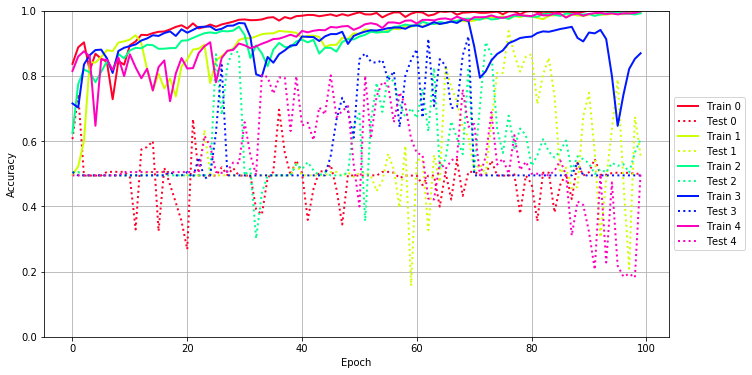

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

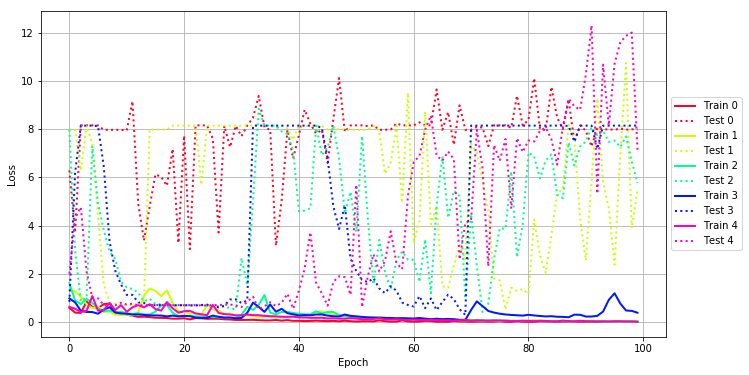

In [12]:
plot_loss(history)

Plotting the confusion matrix


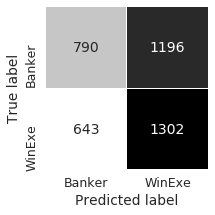

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


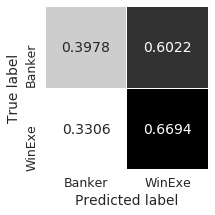

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'val_loss': [6.283383884378431, 3.7087452349500327, 8.151209675372025, 8.151209675372025, 8.151209675372025, 8.151209675372025, 7.966885839362921, 7.966885839362921, 7.966885839362921, 7.966885839362921, 7.939113228006532, 9.14894208217364, 4.913772330956659, 3.3783979078487336, 4.796192508215537, 6.121578549036077, 6.0163912094633165, 5.648072845102234, 7.171656271705482, 3.277474613966754, 7.724182297344281, 3.0217792635151146, 8.151209675372025, 8.151209675372025, 8.151209675372025, 7.598671907012945, 3.712635027181968, 8.130846230017337, 7.248740415258056, 8.133761938372592, 7.703384134790662, 8.151209675372025, 8.461176972831522, 9.374312419449057, 8.063387790285937, 7.966885839362921, 3.16073418465198, 5.051476770531472, 7.964897398573016, 6.776798729228597, 7.753162295724421, 8.803848599236378, 8.220813983196722, 7.81038228174078, 7.966886073486115, 6.587566879834729, 8.417926959054409, 10.111659024540321, 7.88351415270014, 8.148696143715021, 8.151209675372025, 8.15120967537202

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

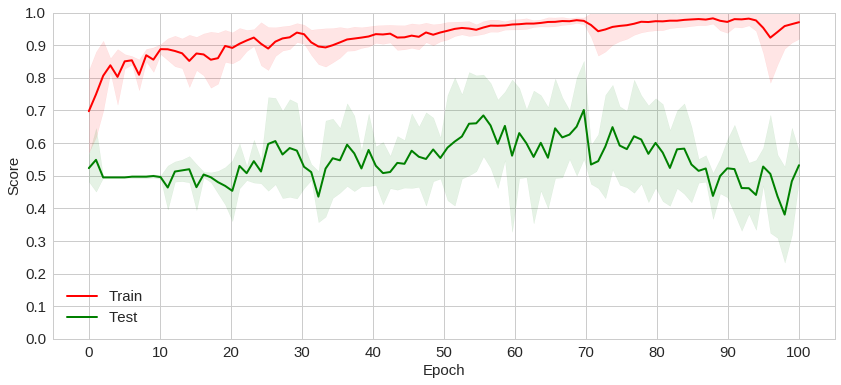

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

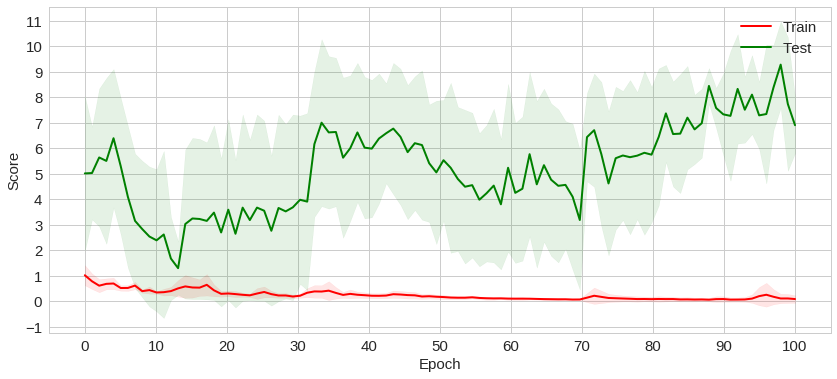

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'val_loss': [6.283383884378431, 3.7087452349500327, 8.151209675372025, 8.151209675372025, 8.151209675372025, 8.151209675372025, 7.966885839362921, 7.966885839362921, 7.966885839362921, 7.966885839362921, 7.939113228006532, 9.14894208217364, 4.913772330956659, 3.3783979078487336, 4.796192508215537, 6.121578549036077, 6.0163912094633165, 5.648072845102234, 7.171656271705482, 3.277474613966754, 7.724182297344281, 3.0217792635151146, 8.151209675372025, 8.151209675372025, 8.151209675372025, 7.598671907012945, 3.712635027181968, 8.130846230017337, 7.248740415258056, 8.133761938372592, 7.703384134790662, 8.151209675372025, 8.461176972831522, 9.374312419449057, 8.063387790285937, 7.966885839362921, 3.16073418465198, 5.051476770531472, 7.964897398573016, 6.776798729228597, 7.753162295724421, 8.803848599236378, 8.220813983196722, 7.81038228174078, 7.966886073486115, 6.587566879834729, 8.417926959054409, 10.111659024540321, 7.88351415270014, 8.148696143715021, 8.151209675372025, 8.151209675372025, 8.118450994109866, 8.151209675372025, 7.966885839362921, 7.966885839362921, 7.982340552910627, 8.235097845986477, 8.151209675372025, 8.151209675372025, 8.151209675372025, 8.277872844392776, 8.151209675372025, 8.151209675372025, 9.639339963241635, 7.966885839362921, 8.70161646092488, 7.346130332771069, 8.983114381303023, 7.966885839362921, 7.966885839362921, 8.090776940767466, 8.059696881410582, 7.291378889332278, 8.151209675372025, 8.151209675372025, 8.151209675372025, 8.052269709458647, 9.377273675901614, 8.151209675372025, 8.373928694137323, 10.107542294862158, 8.000202087313884, 7.951087876681794, 9.745233824171287, 8.470197641048482, 8.000522415492574, 9.217222896055501, 7.4575410917723195, 8.151209675372025, 7.920705444325032, 7.275625343243988, 8.05137803003173, 7.9865759886810705, 7.982166865919137, 7.972460932428093, 8.01732122303689, 7.971315500910165, 7.991212977666842, 7.9737341279675515], 'val_acc': [0.6060991105463787, 0.7433290978398983, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.5057179161372299, 0.5057179161372299, 0.5057179161372299, 0.5057179161372299, 0.4891994917407878, 0.3290978398983482, 0.5743329098218581, 0.5819567980426997, 0.5997458703939009, 0.32401524785210245, 0.5184243964421855, 0.4663278271918678, 0.4116899619562956, 0.3545108005082592, 0.2681067344724299, 0.6670902160101652, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.5196950444726811, 0.49555273189326554, 0.5171537484116899, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.39135959339263027, 0.3748411689961881, 0.4866581956797967, 0.5057179161372299, 0.6963151207115629, 0.5641677255400254, 0.49555273189326554, 0.5412960609911055, 0.5019059720457433, 0.3583227445997459, 0.4536213468869123, 0.5082592121982211, 0.5057179161372299, 0.5273189326556544, 0.45235069885641677, 0.3443456162642948, 0.49555273189326554, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49555273189326554, 0.49428208386277, 0.5057179161372299, 0.5057179161372299, 0.5031766200762389, 0.4866581956797967, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.4650571791613723, 0.49428208386277, 0.49428208386277, 0.39898348157560354, 0.5057179161372299, 0.420584498094028, 0.5438373570520966, 0.4320203303684879, 0.5057179161372299, 0.5057179161372299, 0.49682337992376113, 0.49809402795425667, 0.5400254129606099, 0.49428208386277, 0.49428208386277, 0.49428208386277, 0.49809402795425667, 0.37738246505717915, 0.49428208386277, 0.46886912325285895, 0.3545108005082592, 0.5031766200762389, 0.5031766200762389, 0.3811944091486658, 0.4663278271918678, 0.4993646759847522, 0.4218551461245235, 0.5336721728081322, 0.49428208386277, 0.5044472681067345, 0.5451080050825922, 0.49682337992376113, 0.49682337992376113, 0.5019059720457433, 0.5031766200762389, 0.5019059720457433, 0.5031766200762389, 0.4993646759847522, 0.5006353240152478], 'acc': [0.8368320610687023, 0.8877226463104325, 0.9026717557251909, 0.8164758269720102, 0.8676844783715013, 0.852735368956743, 0.8428753180661578, 0.7283715012722646, 0.8454198473282443, 0.8342875318066157, 0.8937659033078881, 0.9055343511450382, 0.9258905852417303, 0.9249363867684478, 0.9309796437659033, 0.9351145038167938, 0.9360687022900763, 0.9424300254452926, 0.9500636132315522, 0.9551526717557252, 0.94529262086514, 0.9608778625954199, 0.9456106870229007, 0.9497455470737913, 0.9573791348600509, 0.9506997455470738, 0.9576972010178118, 0.9618320610687023, 0.9662849872773537, 0.9720101781170484, 0.9729643765903307, 0.9707379134860051, 0.9710559796437659, 0.9729643765903307, 0.9783715012722646, 0.9799618320610687, 0.9694656488549618, 0.9802798982188295, 0.9755089058524173, 0.9831424936386769, 0.9844147582697201, 0.9869592875318066, 0.9866412213740458, 0.982824427480916, 0.9856870229007634, 0.9885496183206107, 0.9834605597964376, 0.9891857506361323, 0.9847328244274809, 0.9901399491094147, 0.9949109414758269, 0.9885496183206107, 0.9882315521628499, 0.9930025445292621, 0.9793256997455471, 0.9882315521628499, 0.9945928753180662, 0.9945928753180662, 0.9805979643765903, 0.9907760814249363, 0.9958651399491094, 0.9942748091603053, 0.9844147582697201, 0.9882315521628499, 0.9974554707379135, 0.9961832061068703, 0.9980916030534351, 0.9875954198473282, 0.9936386768447837, 0.9945928753180662, 0.9961832061068703, 0.9933206106870229, 0.9933206106870229, 0.9952290076335878, 0.9968193384223919, 0.9891857506361323, 0.9977735368956743, 0.9974554707379135, 0.9885496183206107, 0.9971374045801527, 0.9987277353689568, 0.9958651399491094, 0.9917302798982188, 0.9939567430025446, 0.9920483460559797, 0.9968193384223919, 0.9961832061068703, 0.9958651399491094, 0.9926844783715013, 0.996501272264631, 1.0, 0.9990458015267175, 0.9980916030534351, 0.9984096692111959, 0.9926844783715013, 0.9977735368956743, 0.9891857506361323, 0.9968193384223919, 0.996501272264631, 0.9980916030534351], 'loss': [0.5843521141312049, 0.39019015423820824, 0.3764745924081511, 0.8475374607677375, 0.6288868280521027, 0.5752099961535317, 0.7411574208326922, 0.7621940539500489, 0.39641476564734945, 0.41777859305910786, 0.2975099444882257, 0.25835925752045846, 0.2120251529411657, 0.21957146653635357, 0.20215237445882867, 0.17574098644157252, 0.17153748153749163, 0.16046955891939368, 0.13716509819751174, 0.13752453514604662, 0.15521633759159925, 0.10893280146780966, 0.16005484893936994, 0.15249527460106344, 0.13044379544788, 0.1368193977344165, 0.13224525856915814, 0.11134372830258223, 0.10407725186975858, 0.08393255075790537, 0.08350193472436936, 0.0870740434561285, 0.08961228556627687, 0.07655641768582677, 0.06395496916364755, 0.06378424414978588, 0.08269610886258232, 0.05659899200637453, 0.07796358030986127, 0.04887945175706468, 0.04727934095054704, 0.038517677067286094, 0.042905711873704636, 0.05479445485143422, 0.04433941602696245, 0.036485611305141975, 0.045682582892560455, 0.02870796183370049, 0.0509335938580429, 0.032190970861357124, 0.01736226867306468, 0.03120837428285053, 0.03079959373706691, 0.024541729671807882, 0.06597736611988682, 0.03258578176465764, 0.01490265809626937, 0.016116468065430004, 0.06419216124982953, 0.02386790358831125, 0.013807528960747667, 0.01658781244911133, 0.044558873012763095, 0.036956326437209974, 0.008839072231977938, 0.009980671025618268, 0.005811524696733063, 0.03799070735465453, 0.019908137462321746, 0.015982261619995834, 0.010962554595515228, 0.01396945480408818, 0.01718497742651528, 0.012909830000149742, 0.011736463241622705, 0.030979000556826043, 0.006726010137821314, 0.007234023505653792, 0.02969322489661863, 0.010770846278703531, 0.004670219361784725, 0.009466559018295599, 0.025051643589635963, 0.017682320546233594, 0.019078475944760528, 0.01216936476012121, 0.008706861387316899, 0.012470196111386984, 0.020510284404222253, 0.00745853702255425, 0.0005175953046020145, 0.0016961391232791204, 0.006806035103566381, 0.003968674533266887, 0.02300357866511525, 0.007264048738379781, 0.03261625350274628, 0.00877406067269726, 0.016058636986719936, 0.00559645193053458]},
{'val_loss': [7.977021826435902, 7.977021826435902, 6.286278839940616, 8.14107369800257, 7.366271818563891, 4.3767397042643665, 1.5714790169102242, 0.7936738840192935, 0.7586097845442725, 0.7077250155328795, 0.723379234169579, 0.6973063528689416, 0.7342500190698463, 0.7775674600334265, 7.977021826435902, 7.977021826435902, 7.977021826435902, 7.977021826435902, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 5.68436169502996, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.125087437435567, 8.12541988108819, 8.05329026959116, 8.126026894029884, 8.028867770569356, 7.551350332739699, 8.14107369800257, 8.124896205374, 8.14123547812047, 8.14107369800257, 8.14107369800257, 7.977021826435902, 7.977021826435902, 7.991560841358683, 7.980615952542727, 7.969877634397611, 7.9836760184928695, 7.948810073989109, 7.991111900775941, 8.143019467961924, 7.912730899188629, 6.144770930259337, 6.604791036998953, 8.135464006252871, 4.944382423549208, 9.495182299431955, 3.2562579331845978, 4.178769413257624, 8.719515768929595, 4.0487602852587985, 4.797608009124834, 1.4807751195472547, 1.4207169498897882, 2.3455673139405016, 3.1723976448506654, 2.588022506021669, 7.398045283049228, 7.001806878886403, 5.887248548657079, 4.607775742469679, 1.8060814740501212, 1.723253629992671, 0.5159759383849385, 1.4193621141238493, 1.2922928809882417, 1.3674948298996077, 1.1599871081361994, 4.252022503051604, 2.771127862178038, 2.0351978265134374, 3.5989634083517608, 5.304328782564507, 5.544796590618499, 8.187358013318695, 7.544875603595763, 4.290109228238502, 2.5540762742377976, 5.862844228397355, 9.264773148010098, 5.791965431232792, 4.716680177295481, 2.377011759694627, 6.918406862642322, 10.738747041037367, 3.8925429870760775, 5.505217213667076], 'val_acc': [0.5050890585241731, 0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.6335877862595419, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5305343511450382, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5050890585241731, 0.5050890585241731, 0.49236641221374045, 0.5038167938931297, 0.4910941475826972, 0.5012722646310432, 0.5050890585241731, 0.49363867684478374, 0.44656488549618323, 0.47837150127226463, 0.5610687022900763, 0.5127226463104325, 0.39567430025445294, 0.5852417302798982, 0.15648854961832062, 0.5432569974554707, 0.5432569974554707, 0.32697201017811706, 0.5572519083969466, 0.47455470737913485, 0.8307888040712468, 0.7646310432569975, 0.7213740458015268, 0.6399491094147582, 0.6119592875318066, 0.510178117048346, 0.5292620865139949, 0.49872773536895676, 0.6564885496183206, 0.8091603053435115, 0.8091603053435115, 0.9376590330788804, 0.8651399491094147, 0.8129770992366412, 0.8587786259541985, 0.8664122137404581, 0.7137404580152672, 0.8040712468193384, 0.8549618320610687, 0.7379134860050891, 0.5025445292620865, 0.5190839694656488, 0.455470737913486, 0.4592875318066158, 0.6755725190839694, 0.7480916030534351, 0.5661577608142494, 0.3053435114503817, 0.4821882951653944, 0.6374045801526718, 0.7888040712468194, 0.47455470737913485, 0.20865139949109415, 0.6743002544529262, 0.55470737913486], 'acc': [0.49666136732541133, 0.522734499261944, 0.6003179650617517, 0.841971383166806, 0.8406995230903687, 0.8578696343402226, 0.8788553259520538, 0.875993640699523, 0.9020667726550079, 0.9058823529601286, 0.9112877583465818, 0.9246422894050282, 0.9004769475736755, 0.8197138315543462, 0.7548489666515769, 0.8063593004769475, 0.7612082672801419, 0.7920508744796243, 0.7370429252971716, 0.8292527822129109, 0.8505564389812549, 0.8807631162467556, 0.8833068362669649, 0.8957074721970126, 0.7780604133734832, 0.8476947535771066, 0.8607313195927534, 0.875993640889045, 0.8829888712241654, 0.909697933227345, 0.9160572337232448, 0.9151033386327504, 0.9211446741048027, 0.9278219396055977, 0.9300476947535771, 0.9303656599669464, 0.9376788553259141, 0.9360890302445817, 0.9348171701112877, 0.9319554848966614, 0.9166931637519873, 0.9227344992240396, 0.9233704292906866, 0.9192368839617185, 0.8887122418429401, 0.8950715421493178, 0.8950715421303657, 0.9166931637519873, 0.9131955484896661, 0.9303656598153288, 0.9284578696343402, 0.9424483306836248, 0.9402225755166932, 0.9338632750586978, 0.9338632750586978, 0.939268680445151, 0.9443561208267091, 0.9430842607313196, 0.9519872813990461, 0.9497615262321145, 0.9577106518282988, 0.9507154213036566, 0.9589825119236884, 0.9599364069952305, 0.9599364070141827, 0.9624801271860095, 0.9669316375198728, 0.9691573926868045, 0.967885532591415, 0.9672496025437202, 0.9694753577106519, 0.9758346581875994, 0.9758346581875994, 0.9799682034976153, 0.9783783783783784, 0.9828298887122416, 0.9745627980922098, 0.983147853736089, 0.9802861685214627, 0.9850556438981255, 0.982193958664547, 0.978060413354531, 0.9736089030206677, 0.9841017488265833, 0.9860095389507154, 0.9872813990461049, 0.9809220985691574, 0.9888712241653418, 0.9853736089030206, 0.9834658187599364, 0.9879173290937997, 0.9914149443561209, 0.9872813990461049, 0.9882352941176471, 0.9901430842796836, 0.9895071544025585, 0.9895071542130366, 0.9936406995230525, 0.9939586645468999, 0.9958664546899841], 'loss': [1.3062720879462262, 1.271869016717083, 1.0586677213920508, 0.734551088334267, 0.5803184088538674, 0.6444531532534544, 0.4221022362170803, 0.43367644325254073, 0.29801318748707517, 0.29048701899987905, 0.3028147972314744, 0.26658440555411794, 0.411060347731428, 1.0937120705227026, 1.3892968437819488, 1.2913321984970323, 1.0684391383999672, 1.308213027482571, 0.7932692905488189, 0.44944111382639085, 0.4144795688470331, 0.34665387595022046, 0.3357486210491017, 0.2962389668760694, 0.7117394382983967, 0.5107073650119415, 0.4795378223416915, 0.33450573658147187, 0.3550873686522482, 0.25724082416684524, 0.2545140568184739, 0.2686798918559934, 0.254882862273195, 0.21235355806843464, 0.2238799840472461, 0.22627381780947334, 0.18645753335497905, 0.21411257931083108, 0.20413353016602975, 0.22579793017979458, 0.24295304991861594, 0.23732146775210794, 0.31414066327584755, 0.40895092039115855, 0.4340149855575804, 0.351537465916529, 0.3118388790204908, 0.2491026934763396, 0.23580296720201904, 0.20556230401007283, 0.20901589318873015, 0.17345429898635004, 0.1765981336845313, 0.18460833615547903, 0.2053926876741676, 0.1713471068060455, 0.15201030585837857, 0.1465844109713652, 0.131646863341521, 0.13721514346051386, 0.12520620087798334, 0.13819761065401978, 0.11772250341094545, 0.1133866095865095, 0.11115112534482832, 0.10039941426751534, 0.09067116123172551, 0.08596730742289645, 0.09681241060051896, 0.09026283019819017, 0.07461175840882517, 0.0671345529346379, 0.06586453108700356, 0.055195762981943466, 0.06327544645908242, 0.04940343632441257, 0.0638469471544359, 0.048227996757588626, 0.05463358306567316, 0.04662334008411829, 0.050011749593437384, 0.06858882911552176, 0.0823883972878439, 0.040100736105118676, 0.045916372839959606, 0.03454157454472491, 0.04975155547397457, 0.03158644333208611, 0.03562975630574284, 0.04724573593594827, 0.03485070681110593, 0.02363403645938278, 0.035861998931497385, 0.030668621643969052, 0.02637351643796033, 0.027312398574349066, 0.03236377506038627, 0.017957052532508518, 0.019234791745202963, 0.014292483080499798]},
{'val_loss': [7.977021826435902, 2.980469897806493, 0.8612509160551406, 1.005503459210311, 7.296865644042481, 4.884317477158208, 3.8093505183420837, 2.9121268186943357, 2.614734279102013, 1.6669131664905232, 1.4381158140703618, 1.3664613374847796, 1.2216309596412358, 0.8506224113717941, 0.9618320588695487, 0.7401434569868423, 0.7399670575714596, 0.7363417834119336, 0.6886833854607347, 0.68552362767188, 0.7021075374904177, 0.6882205035243629, 0.6828886534421499, 0.6929471805198806, 0.6718213618863327, 0.6600677709239736, 0.6563321009240382, 0.6363498509385204, 0.579712135949511, 0.5174043177800021, 2.6541554074445335, 1.5173161505098258, 5.022624959434565, 8.839402563841515, 8.14107369800257, 8.14107369800257, 8.14107369800257, 7.899096404323141, 7.801549858416006, 7.107700776204505, 4.588470114495672, 4.618912597122065, 4.723472192318411, 8.14107369800257, 6.914950983118948, 7.226859427580932, 8.14107369800257, 6.780000793357063, 4.50247757265745, 5.397067754171585, 3.737816375304253, 7.712652910150037, 4.33260367706608, 1.5466571781480085, 3.4054261926051104, 2.076495684875349, 1.3505135703329518, 2.5695764833166526, 2.9248789875081833, 2.591451696475557, 2.5788169976300477, 1.656341823146432, 3.4232400973442183, 1.192713518152477, 4.8595747802438405, 6.869287524371515, 4.318688064406975, 5.439673026577567, 5.217816513910464, 0.9718417660801247, 4.475027046949424, 2.3492182014243164, 0.4139135496378225, 0.7590182503461856, 2.619110816759348, 3.8865899377272632, 3.862831786787004, 6.242794322143794, 2.683507820781833, 4.046491000826918, 7.023262603477113, 6.860010892986948, 5.9550842017921175, 6.692772015057144, 6.947359100991621, 5.270037977694926, 5.132584402907817, 7.437764136239701, 6.4837104282038736, 7.280949611093555, 7.481178476306925, 8.075076746576615, 7.7462937586180125, 7.9337366846681645, 7.463829825246, 7.523462396918419, 7.2532772071080895, 7.691893979946568, 6.661763456193452, 5.763869686284441], 'val_acc': [0.5050890585241731, 0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.8664122137404581, 0.6806615776081425, 0.8320610687022901, 0.8829516539440203, 0.8689567430025446, 0.494910941475827, 0.5152671755725191, 0.3015267175572519, 0.44147582697201015, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5292620865139949, 0.5139949109414759, 0.5356234096692112, 0.510178117048346, 0.494910941475827, 0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5038167938931297, 0.6463104325699746, 0.6844783715012722, 0.3549618320610687, 0.6603053435114504, 0.7786259541984732, 0.6895674300254453, 0.7989821882951654, 0.7824427480916031, 0.7150127226463104, 0.6730279898218829, 0.7010178117048346, 0.6704834605597965, 0.7595419847328244, 0.6297709923664122, 0.8244274809160306, 0.5165394402035624, 0.544529262086514, 0.6603053435114504, 0.6094147582697201, 0.5597964376590331, 0.8256997455470738, 0.5076335877862596, 0.7073791348600509, 0.9033078880407125, 0.8651399491094147, 0.6361323155216285, 0.5636132315521628, 0.678117048346056, 0.5788804071246819, 0.638676844783715, 0.6183206106870229, 0.5241730279898219, 0.5559796437659033, 0.6055979643765903, 0.5674300254452926, 0.549618320610687, 0.5699745547073791, 0.6017811704834606, 0.5076335877862596, 0.5534351145038168, 0.544529262086514, 0.5318066157760815, 0.49872773536895676, 0.5139949109414759, 0.5038167938931297, 0.5330788804071247, 0.5241730279898219, 0.5292620865139949, 0.5038167938931297, 0.5648854961832062, 0.6055979643765903], 'acc': [0.6248012719359042, 0.7748807633055792, 0.8193958666442119, 0.8111287758536104, 0.780604133734832, 0.8120826710957222, 0.8445151033765371, 0.8158982511923688, 0.8670906201076053, 0.8537360890491589, 0.878219395904359, 0.8858505564766961, 0.8845786963434022, 0.8953895072110696, 0.8941176470777757, 0.8829888712241654, 0.8833068362859171, 0.8852146264290014, 0.8852146264100492, 0.9077901431221651, 0.9087440381558028, 0.9163751988039487, 0.9240063593762857, 0.9306836249907938, 0.9332273449920508, 0.9306836249907938, 0.9376788553259141, 0.9364069952305246, 0.9386327505869781, 0.9510333865170258, 0.925596184438666, 0.8546899841396532, 0.8934817170679854, 0.86931637538825, 0.829570747217806, 0.8804451510712907, 0.9011128776213702, 0.8883942766295707, 0.8880763116057234, 0.905246422912434, 0.9109697933416867, 0.9027027027027027, 0.9106518284884091, 0.8683624801840426, 0.8861685214815913, 0.8858505564766961, 0.8744038155992384, 0.9036565979637667, 0.9125596184419714, 0.9116057233704292, 0.9205087440381559, 0.9259141494625134, 0.9354531001589825, 0.9325914150012127, 0.9351351351730395, 0.9344992051253448, 0.9500794912938663, 0.9519872814179983, 0.9573926868044516, 0.9542130365659778, 0.953577106518283, 0.9656597774434355, 0.9605723370429253, 0.9589825119615928, 0.9656597774244833, 0.9615262323039894, 0.9672496027332421, 0.9678855327809369, 0.9748807631160572, 0.9751987281399046, 0.9742448330683625, 0.972019077920383, 0.9793322734499205, 0.9729729729919252, 0.9745627982817318, 0.9793322734878249, 0.9748807631539617, 0.9837837837837838, 0.9844197138314785, 0.983147853925611, 0.9818759938302214, 0.9812400635930048, 0.9891891891891892, 0.9904610492845787, 0.9872813990461049, 0.9837837837837838, 0.9910969793322735, 0.9898251192558362, 0.9895071542130366, 0.9879173290937997, 0.989825119236884, 0.9837837837837838, 0.9888712241653418, 0.9914149443561209, 0.9942766295707473, 0.9939586645468999, 0.9914149443561209, 0.9907790143084261, 0.9882352941176471, 0.9920508744038156], 'loss': [1.6068684622290024, 0.8936240278859586, 0.7377716800508893, 0.9574964696727989, 0.7886088697586227, 0.5703033048890543, 0.4408061621488562, 0.47682585712930925, 0.4026713394777574, 0.4251869961264024, 0.35901808596567053, 0.33613589683663103, 0.35941989933553675, 0.31351779219835096, 0.31333020408600804, 0.42810675757263444, 0.6931556308402166, 0.6995324392765997, 0.38192045710897976, 0.25206690523506914, 0.2585060137917772, 0.2514119479349194, 0.22981980466691035, 0.23171058557749932, 0.21014452699352712, 0.20758446167639216, 0.19444758677781102, 0.18334475733422703, 0.18257909535603606, 0.16296975023464103, 0.29953629680581995, 0.628000982198124, 0.497413503555122, 0.7146829427141453, 1.1173156886487394, 0.3864995669484707, 0.3178162720605186, 0.41629397425273457, 0.4180940504388703, 0.3744569249676218, 0.33733778453782937, 0.3233179075812213, 0.3133450742461534, 0.4423433768351241, 0.3567500865326777, 0.4115968011331482, 0.413583120386248, 0.2876422803807524, 0.25151137227639675, 0.23946263964727688, 0.22318857881123577, 0.19807992635356983, 0.18048744538535375, 0.18043526960670095, 0.17229935480414968, 0.1707859376608283, 0.1523407442391582, 0.1341789139378431, 0.12289595390493806, 0.130302813298562, 0.1283286946459965, 0.11172882644000606, 0.10991221121697434, 0.10603447577106176, 0.09425082111668985, 0.10709896495592423, 0.08785925569140096, 0.09168599985054263, 0.06689150045745797, 0.06547019227181335, 0.07474098164878419, 0.08226456593112082, 0.053342705250781365, 0.07125987780705355, 0.06525668557111429, 0.056493383761797404, 0.0621514054080427, 0.04754970500301955, 0.043357113829705814, 0.042489858981760865, 0.053180508405586115, 0.04618634927354528, 0.03479701849278092, 0.02893988835589815, 0.03368372290940446, 0.04578459269969779, 0.025150499250354848, 0.029241570248897817, 0.03642872340780267, 0.03415081519063485, 0.026778173564461008, 0.05055314127458718, 0.03442898503675337, 0.021913969203968944, 0.021564185729823875, 0.020727273337365335, 0.021679794353200492, 0.023938466121532564, 0.03314298460110489, 0.027238418571932304]},
{'val_loss': [0.8303005959241445, 6.179731211595299, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.116204977945516, 6.442089311344517, 3.351890216141041, 2.1234856796860884, 1.5569989684466794, 1.1224677266207057, 1.1247818908315275, 0.8105098004559524, 0.7902453218707601, 0.7010423371203376, 0.6935556359570142, 0.6960063579731618, 0.6970187378597017, 0.6897182014152294, 0.695702817603832, 0.6950219234134102, 0.686710261509922, 0.6896222083623172, 0.7038982536349891, 0.7188627509822069, 0.6578384000836438, 0.6119539839317477, 0.6694926701429236, 0.9345346424946651, 0.9395618105056025, 0.7864917560407072, 0.891492282085443, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.039661747505344, 6.773607929907834, 4.79882026016333, 3.8551149476727153, 4.8408822864673215, 2.6336382914135474, 2.102693544089341, 1.750272998335102, 1.6490689734466213, 1.8172011174727833, 1.3902705851420956, 1.195349069610807, 1.4834073115927113, 1.2959868607440674, 0.8039200710507143, 0.7077072512159366, 0.6408125527828704, 1.0746559455336733, 0.5729967387483168, 0.9773415032153329, 0.4906154976584226, 0.8292530087033422, 1.1317139390398065, 0.9470790715084788, 0.5264964583424647, 0.2936106719048196, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.124899955520895, 7.475392292777394, 8.14107369800257, 8.14107369800257, 8.13971391858642, 7.178121783319346, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257, 8.14107369800257], 'val_acc': [0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.5050890585241731, 0.48854961832061067, 0.549618320610687, 0.4847328244274809, 0.494910941475827, 0.6259541984732825, 0.8333333333333334, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.49363867684478374, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.55470737913486, 0.6653944020356234, 0.732824427480916, 0.6921119592875318, 0.6106870229007634, 0.851145038167939, 0.8689567430025446, 0.8435114503816794, 0.8396946564885496, 0.8486005089058524, 0.7862595419847328, 0.8142493638676844, 0.6424936386768448, 0.8002544529262087, 0.8486005089058524, 0.8816793893129771, 0.6717557251908397, 0.9134860050890585, 0.7073791348600509, 0.851145038167939, 0.8320610687022901, 0.7010178117048346, 0.7048346055979644, 0.8625954198473282, 0.9211195928753181, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5343511450381679, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827], 'acc': [0.7154213036850261, 0.7030206677834067, 0.8349761528127334, 0.863275039745628, 0.8791732909948534, 0.8804451510902429, 0.8537360890870632, 0.8089030207245831, 0.8763116057233704, 0.8861685214626391, 0.8912559618441971, 0.8963434022826118, 0.9084260731509077, 0.914785373798425, 0.9246422893481717, 0.92241653418124, 0.9313195548489667, 0.9364069952305246, 0.922416534370762, 0.9427662957453765, 0.9322734501100307, 0.9408585055643879, 0.9497615262321145, 0.950715421341561, 0.9513513513703036, 0.9402225755166932, 0.944356121016231, 0.9535771065372352, 0.9542130365659778, 0.9621621621811144, 0.9608903020667726, 0.9192368839427663, 0.8047694754335194, 0.7980922098948201, 0.8578696343402226, 0.8403815580665213, 0.8664546900220061, 0.8782193959233112, 0.8928457870202906, 0.8944356121205753, 0.9208267090999076, 0.9195548490234703, 0.9189189189568233, 0.9068362480127186, 0.9211446741237549, 0.9281399046104929, 0.9281399046104929, 0.9351351351351351, 0.897933227534514, 0.9224165342001922, 0.9300476947725294, 0.9357710651828299, 0.939904610511798, 0.9389507154213037, 0.9421303656787297, 0.9462639109697933, 0.9481717011128776, 0.948171701150782, 0.9443561208267091, 0.9532591415133878, 0.955166931656472, 0.9497615262321145, 0.9564387917518615, 0.9650238475663104, 0.9589825119615928, 0.9624801271860095, 0.9666136724960255, 0.9621621621621622, 0.972972972972973, 0.967885532591415, 0.8906200318344067, 0.7942766296276038, 0.8136724960443894, 0.8476947535960587, 0.8670906200697008, 0.8782193960559767, 0.9001589825498281, 0.9074721782499353, 0.9160572338938144, 0.9189189189568233, 0.920508744057108, 0.9313195550384885, 0.9364069952684291, 0.9351351351730395, 0.939268680634673, 0.9437201908169187, 0.946899841017488, 0.9503974563177136, 0.9163751987281399, 0.9055643879173291, 0.9329093801577254, 0.9303656597774245, 0.9408585055643879, 0.9128775834658187, 0.7993640699617813, 0.6467408585624209, 0.7418124007117388, 0.8213036566546308, 0.8521462639678263, 0.86931637538825], 'loss': [0.9786025124248147, 0.814685340166471, 0.4634064540290681, 0.41552282809642616, 0.4125895422668639, 0.341962438471177, 0.5120932554971244, 0.6127967379430519, 0.390639221727469, 0.3557185219953189, 0.34097294442367476, 0.30964178563301437, 0.3118120998854857, 0.29280783209256794, 0.27511070231849327, 0.2718650829514847, 0.2667804567608242, 0.23192741851365292, 0.2659415455946672, 0.2331316132613699, 0.25316139365796636, 0.2394728044370731, 0.1849207419594113, 0.16547310452298253, 0.17881876041428652, 0.26277652600327056, 0.21670784636597565, 0.18077653253921833, 0.1841168420387814, 0.1529230489201595, 0.16746353839416003, 0.38212740404712, 0.8033684557306747, 0.6229352737458598, 0.4180029720731305, 0.7221667191656291, 0.4241502375974185, 0.5464811644607205, 0.3625831126787704, 0.3196447152022527, 0.2687073267700183, 0.2860686256225992, 0.276357346422532, 0.3096864737155707, 0.3120031054618817, 0.265162018540838, 0.23831210025543248, 0.22626442108392147, 0.3089779494108191, 0.2546185001020212, 0.23194103226752652, 0.21099668965513546, 0.19112925771594236, 0.1824829893290333, 0.17736420262077843, 0.16989481937027698, 0.1660243657629327, 0.15191779180247758, 0.1601719063172185, 0.15060747112302977, 0.14232942028436069, 0.16570963700063562, 0.13907679859519195, 0.11376886614887059, 0.13538244283729972, 0.11582936277355413, 0.12696424988772134, 0.11612684427744255, 0.08855471191594647, 0.08409191909496375, 0.4964378496717857, 0.8549783594468061, 0.6575604811571361, 0.45542934438856303, 0.38988128587816784, 0.3417351161685013, 0.311233474435033, 0.29252306389694943, 0.2785058204055022, 0.26442601998204834, 0.2987644970701306, 0.2709456858081545, 0.24886166521589403, 0.22980650905963915, 0.23926781192303462, 0.21703264490599095, 0.2119554249181846, 0.19757589464015157, 0.3031848834883807, 0.2991527949647892, 0.22550041011293287, 0.22635878699880527, 0.25447834724936463, 0.43252979260654634, 0.9170180988994047, 1.1902536025297472, 0.7668025170676469, 0.4764389531221981, 0.46037073434820613, 0.3835196252089047]},
{'val_loss': [2.0056492587214967, 4.3004121331787735, 4.760140215858352, 2.085005510555765, 1.0177036290253696, 0.981721812418399, 0.6931477879143246, 0.7393898097916717, 0.6955686334435266, 0.7970288843295653, 0.7256777732426883, 0.7569688871009963, 0.6950567790873481, 0.6931150284128942, 0.7068067481196261, 0.7047278227393561, 0.7062952783878219, 0.7025791561330548, 0.69571477887588, 0.6954931490900559, 0.6931366222808683, 0.6981311420751285, 0.6954587418917785, 0.6886686531035348, 0.684635344352431, 0.6999510848188522, 0.7030082150876674, 0.71490199753953, 0.7231436212554233, 0.6888116595095958, 0.6199413507645973, 0.8386866677808398, 1.0490503585672257, 0.5244849076252858, 0.6456192827027566, 0.8200334537651096, 0.6582399183936398, 0.7994836644523092, 1.1712899617945571, 0.5490958342380803, 1.3092470295361716, 2.2183351459829717, 3.716452587785257, 1.6257176848567438, 1.1845596059617698, 0.6758883718789838, 1.6638721384679414, 1.8962981719265954, 1.8598157814336567, 1.1251898717334252, 5.689011180977178, 0.6129383400708209, 1.8840135490499128, 2.8055428644456106, 2.0948695265090485, 2.5273886616024672, 3.761548044861471, 2.4436746483846603, 2.1892798463159453, 5.233522012154795, 6.632240416659676, 6.883916793282099, 7.9804060152392955, 8.559923319567858, 6.900685648699279, 6.691502857267245, 7.067591524547864, 6.746768308262982, 2.5939305381893023, 4.111759776570411, 4.208522163009472, 7.966244355716172, 6.363100696664402, 2.3050275598317858, 7.335876790318477, 6.684662464846894, 7.583359815376771, 4.697802715910729, 7.6251622981394656, 7.0420585276031575, 7.528185131161002, 7.482134632083244, 7.925101186712894, 8.053307997058063, 7.573872862618924, 6.519423120417431, 8.101227874670927, 9.262277899200983, 8.940779692647414, 8.794920795139769, 10.259703391077561, 12.29343345389718, 5.321614238900386, 10.669024926105529, 8.151996460808054, 10.703873798728884, 11.59109673730593, 11.862624277595346, 11.998249801363958, 7.14320073151235], 'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.5050890585241731, 0.6157760814249363, 0.5852417302798982, 0.5050890585241731, 0.5025445292620865, 0.5076335877862596, 0.5343511450381679, 0.5318066157760815, 0.6577608142493638, 0.5572519083969466, 0.4961832061068702, 0.8027989821882952, 0.7964376590330788, 0.7455470737913485, 0.7951653944020356, 0.7938931297709924, 0.6310432569974554, 0.7989821882951654, 0.6475826972010178, 0.6564885496183206, 0.6030534351145038, 0.7035623409669212, 0.6819338422391857, 0.8015267175572519, 0.6730279898218829, 0.6921119592875318, 0.7073791348600509, 0.5292620865139949, 0.3994910941475827, 0.8002544529262087, 0.6081424936386769, 0.7379134860050891, 0.7811704834605598, 0.772264631043257, 0.6577608142493638, 0.7493638676844784, 0.7111959287531806, 0.6068702290076335, 0.5636132315521628, 0.5572519083969466, 0.42366412213740456, 0.4211195928753181, 0.5343511450381679, 0.5139949109414759, 0.5407124681933843, 0.5508905852417303, 0.7582697201017812, 0.6437659033078881, 0.6526717557251909, 0.494910941475827, 0.5521628498727735, 0.688295165394402, 0.5279898218829516, 0.5458015267175572, 0.5, 0.6183206106870229, 0.5114503816793893, 0.5368956743002544, 0.5, 0.5, 0.49745547073791346, 0.494910941475827, 0.5089058524173028, 0.5407124681933843, 0.4961832061068702, 0.3104325699745547, 0.41475826972010177, 0.40458015267175573, 0.32188295165394404, 0.20610687022900764, 0.49745547073791346, 0.227735368956743, 0.4732824427480916, 0.21755725190839695, 0.18447837150127228, 0.19338422391857507, 0.18193384223918574, 0.5050890585241731], 'acc': [0.8149443561397789, 0.8594594595163161, 0.8753577106518283, 0.8597774245212112, 0.647058823548364, 0.8502384737868377, 0.8492845787152956, 0.8181240063972048, 0.85627980925889, 0.7993640699902096, 0.8661367249981587, 0.8260731319933893, 0.7926868044704626, 0.8219395866833734, 0.7551669317133286, 0.8270270270649314, 0.8473767885532592, 0.722098569195297, 0.8073131956053462, 0.8546899841017488, 0.8225755168826857, 0.8238473769780752, 0.8702702702702703, 0.8909379968203498, 0.9030206677265501, 0.7802861685214626, 0.8550079493151181, 0.8769475357900174, 0.8798092210235959, 0.8992050874403815, 0.8937996820349762, 0.884896661405154, 0.8906200317965024, 0.8985691573926868, 0.9049284579264909, 0.9128775834658187, 0.9141494435612083, 0.919872814179983, 0.9262321146569306, 0.919872814179983, 0.9376788553448664, 0.9335453100158982, 0.9383147853736089, 0.9408585057539098, 0.9399046104928458, 0.9500794912938663, 0.9481717013023995, 0.9516693163751987, 0.9529411765084926, 0.9411764705882353, 0.9481717011318298, 0.9583465818759936, 0.9615262321144674, 0.9580286168521462, 0.9465818759936407, 0.9637519873193034, 0.963751987470921, 0.9608903020667726, 0.9691573926868045, 0.9701112877583465, 0.9605723370429253, 0.9717011128965357, 0.9717011128775834, 0.9701112877772988, 0.9748807631160572, 0.9761526232114467, 0.9723370429252782, 0.9815580288063741, 0.9748807631350094, 0.9691573926868045, 0.9799682034976153, 0.9796502384737679, 0.9802861685214627, 0.9853736089030206, 0.9796502384737679, 0.9777424483306836, 0.982193958664547, 0.9882352941176471, 0.9866454689984102, 0.9844197138314785, 0.983147853736089, 0.9901430842607313, 0.985691573926868, 0.9853736089030206, 0.9910969793322735, 0.9901430842607313, 0.978696343421178, 0.9875993640699523, 0.9914149443561209, 0.9844197138314785, 0.989825119236884, 0.992368839427663, 0.993322734688727, 0.989825119236884, 0.9917329093799682, 0.9885532591414944, 0.9917329093989204, 0.9914149443561209, 0.9930047694753578, 0.9980922098569157], 'loss': [0.6260401569223935, 0.5475632915436179, 0.42066429314604814, 0.45939482048698754, 1.0768525521023664, 0.4668049656056069, 0.4936134734337584, 0.7883765899320097, 0.49623304372372046, 0.6984279743249162, 0.4235858341089682, 0.6108949134762981, 0.6967158813355269, 0.6070970798334749, 0.734119229191627, 0.535832907626663, 0.47065158035541, 0.8269578193822233, 0.5659175369811551, 0.3863300941138275, 0.445317008082173, 0.4610938620681035, 0.35672428090545827, 0.31833487312725506, 0.2853732697677536, 0.7071452727378457, 0.3752974435331711, 0.3251597553538973, 0.3099801146263917, 0.2738494726214765, 0.27846838095845783, 0.30654798391703014, 0.2858326137729214, 0.28068942680173153, 0.25407636688699403, 0.23971414981329953, 0.23364017376460028, 0.21678663556640212, 0.21322448296274024, 0.2206300144354755, 0.1867060608012877, 0.18606299618777297, 0.17356009599656483, 0.17009609687498908, 0.17538959203208004, 0.1466927293753207, 0.1545036383150871, 0.14147102822370483, 0.14061629033998388, 0.1583030598483897, 0.14371575074468773, 0.11468519155403957, 0.11759651063072284, 0.12627323321133427, 0.1566992798059089, 0.10688260965677059, 0.10426549522505277, 0.11018902139533873, 0.09409153697766447, 0.08136972461091221, 0.10085297862396521, 0.0806051288966818, 0.08903397179145028, 0.09013500690270683, 0.07736791347305991, 0.07211128339135875, 0.07545322206268155, 0.05978031161526997, 0.06954426377691886, 0.09574397195645849, 0.049859040519237424, 0.06559848801717044, 0.06636007854652803, 0.04988126150333872, 0.06275975118392696, 0.06263824502459249, 0.04871531455349681, 0.038708579385451775, 0.037812027072797516, 0.0529063544584074, 0.04287671069088962, 0.03439765948363963, 0.04429047777153113, 0.04355288276268208, 0.02983628781971378, 0.026877289397171173, 0.0572199748874907, 0.0384758422322592, 0.02418021645014943, 0.04937806995304239, 0.03353255019724571, 0.027191039901215654, 0.023469072857605876, 0.02953741068719325, 0.017478091480246143, 0.032595512839345135, 0.028110169758427953, 0.020779250154348713, 0.021774487430859055, 0.005410708005617621]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 1 - Max val_acc: 0.7433
[1] Epoch: 76 - Max val_acc: 0.9377
[2] Epoch: 72 - Max val_acc: 0.9033
[3] Epoch: 69 - Max val_acc: 0.9211
[4] Epoch: 33 - Max val_acc: 0.8028


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

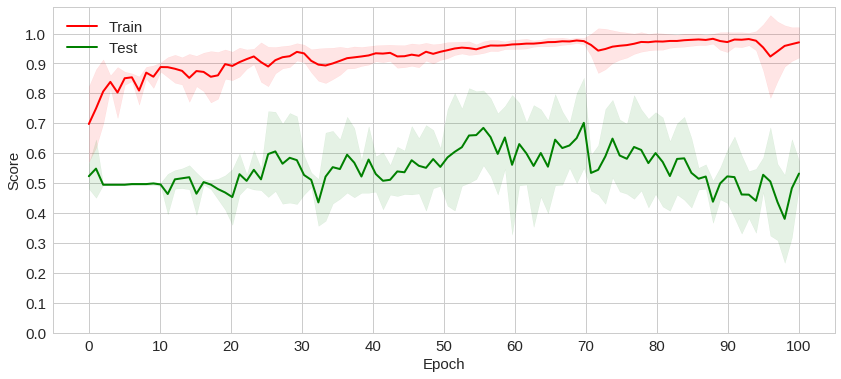

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

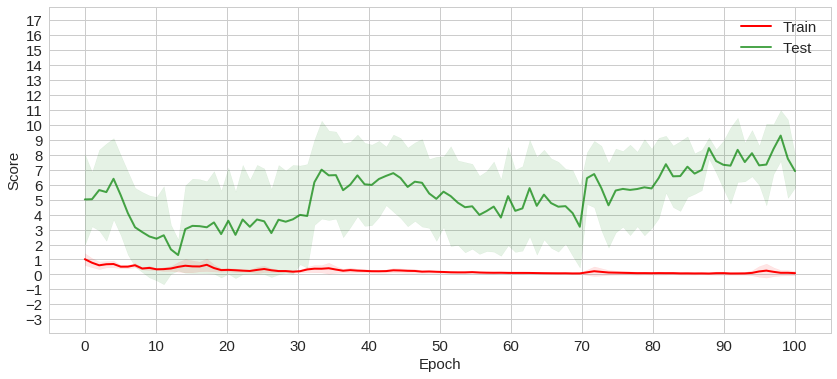

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

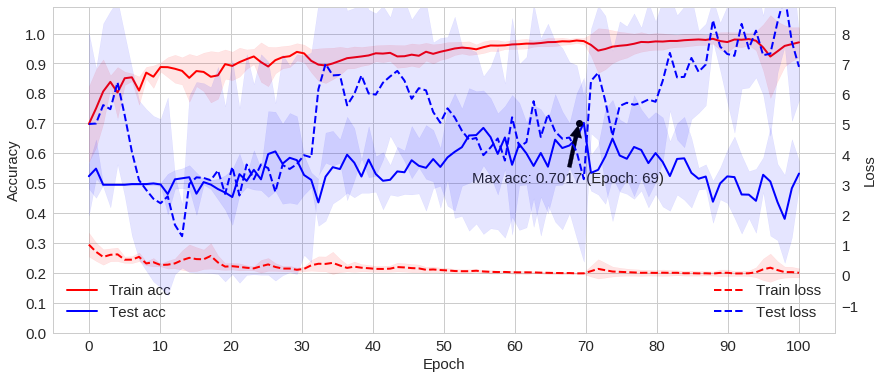

In [28]:
plot_mean(hist)